# 0 CARREGAMENTO DAS BIBLIOTECAS

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import patsy as pt
from google.colab import drive
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge

# 1 CARREGAMENTO DOS DADOS

## 1.1 Montar o Google Drive

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Nova seção

## 1.2 Ler o arquivo

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/DNC/Estatística Avançada/50_Startups.csv')

In [4]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# 2 EDA

## 2.1 Estatísticas descritivas

In [5]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


## 2.2 Análise gráfica

### 2.2.1 Nome das colunas

In [6]:
contColNames = list(df.select_dtypes(include='number').columns)

### 2.2.2 Cofigurarar tamanho do subplot

In [7]:
ncols = 3

In [8]:
nrows = int(np.ceil(len(contColNames)/(1.0 * ncols)))

### 2.2.3 Plotar os histogramas

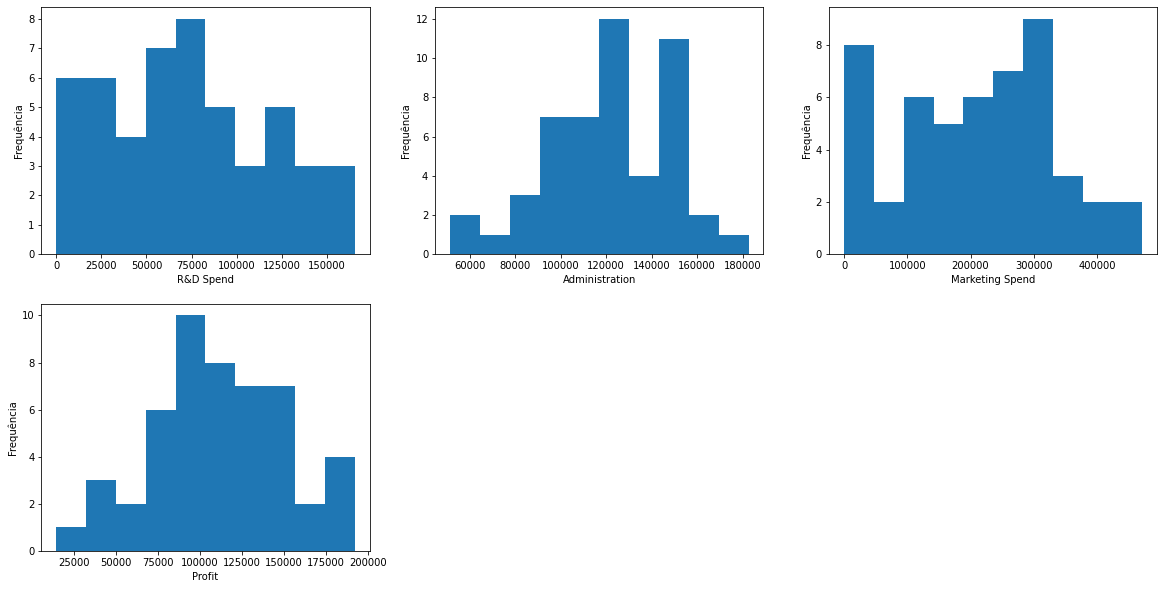

In [9]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

counter = 0 

for i in range(nrows):
  for j in range(ncols):

    ax = axes[i][j]

    # Plotar somente quando houver dados
    if counter < len(contColNames):

      ax.hist(df.select_dtypes(include='number')[contColNames[counter]], bins=10)
      ax.set_xlabel(contColNames[counter])
      ax.set_ylabel('Frequência')

    else:
      ax.set_axis_off()

    counter += 1

plt.show()

### 2.2.4 Plotar o gráfico de barras

Text(0.0, 1.0, 'Distribuição dos estados')

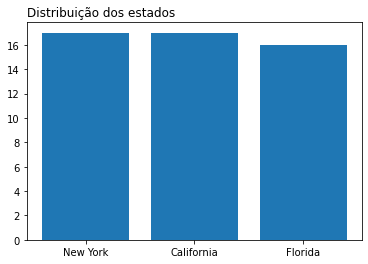

In [10]:
fig = plt.figure()

plt.bar(df['State'].unique(), df['State'].value_counts())

plt.title('Distribuição dos estados', loc='left')

### 2.2.5 Plotar gráfico de correlação

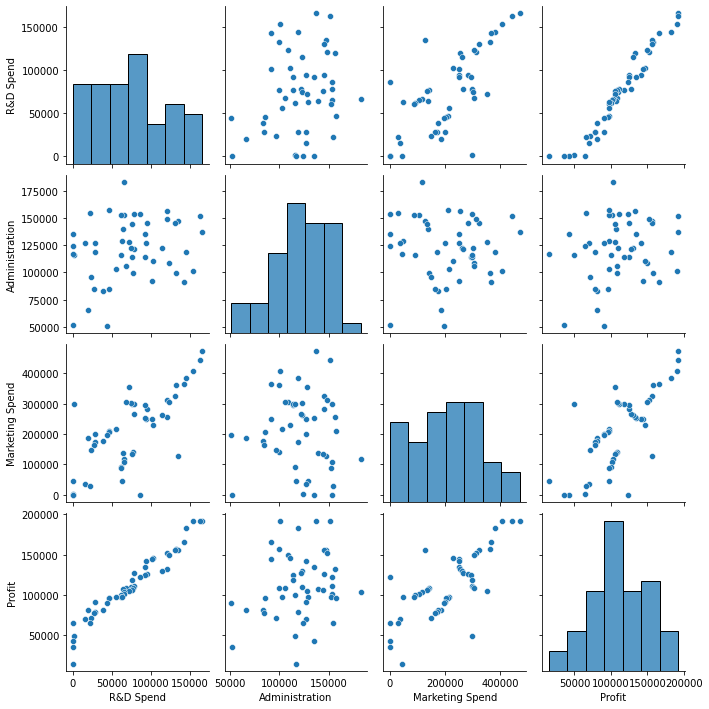

In [11]:
sns.pairplot(df)

### 2.2.6 Plotar o box-plot

Text(0, 0.5, '')

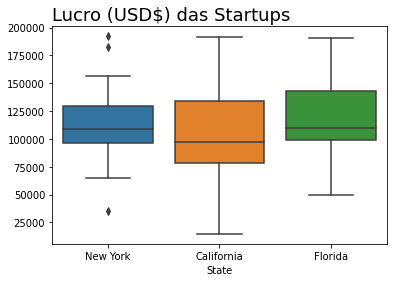

In [12]:
fig = plt.figure()

sns.boxplot(x = df['State'], y = df['Profit'])

plt.title('Lucro (USD$) das Startups', fontsize = 18, fontweight = 18, loc = 'left')

plt.ylabel('')

# 3 PRÉ-PROCESSAMENTO DOS DADOS

## 3.1 Separar as variáveis

### 3.1.1 Variáveis contínuas

In [13]:
dfNum = df.select_dtypes(include='number').drop(['Profit'], axis = 1)


In [14]:
dfNum.head()

,R&D Spend,Administration,Marketing Spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


### 3.1.2 Variáveis categoricas

In [15]:
# Mudar o tipo de variável para 'categórico'
df['State'] = df['State'].astype('category')

# Selecionar somente as variáveis categóricas
dfCat = df.select_dtypes(include='category')

In [16]:
dfCat.head()

,State
0,New York
1,California
2,Florida
3,New York
4,Florida


### 3.1.3 Resposta

In [17]:
y = df['Profit']

## 3.2 Pré-tratamento da resposta


### 3.2.1 Teste resposta original

In [18]:
kStat, kPvalue = sp.stats.kstest(rvs=y, cdf='norm')

In [19]:
kStat

1.0

In [20]:
kPvalue

0.0

### 3.2.3 Teste log da resposta

In [21]:
kStat, kPvalue = sp.stats.kstest(rvs=np.log(y), cdf='norm')

In [22]:
kStat

1.0

In [23]:
kPvalue

0.0

(array([ 1.,  0.,  0.,  1.,  2.,  2.,  6., 17., 11., 10.]),
 array([ 9.59433667,  9.85156434, 10.10879202, 10.36601969, 10.62324737,
        10.88047504, 11.13770272, 11.39493039, 11.65215807, 11.90938574,
        12.16661342]),
 <a list of 10 Patch objects>)

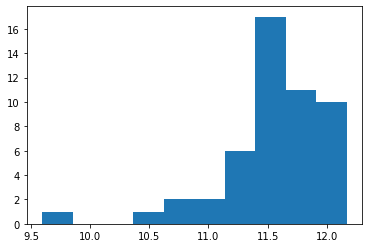

In [24]:
fig = plt.figure()
plt.hist(np.log(y))

## 3.3 Pré-tratamento das vaiáveis contínuas

In [25]:
# Criar a função para o escalonamento dos dados
def feat_scale(X):

  # Calcular a média de todas as variáveis
  mu = np.mean(X, axis = 0)

  # Calcular o devio padrão de todas as variáveis
  sigma = np.std(X, axis=0, ddof=1)

  # Fazer os escalonamento das variáveis
  xNorm = (X - mu)/sigma

  return xNorm

In [26]:
dfNorm = feat_scale(dfNum)

In [27]:
dfNorm.head()

,R&D Spend,Administration,Marketing Spend
0,1.996146,0.555117,2.132295
1,1.936203,1.071924,1.904267
2,1.736731,-0.720938,1.610180
3,1.539157,-0.095396,1.407916
4,1.489812,-1.069066,1.268648


## 3.4 Pré-tratamento das variáveis categóricas

In [28]:
dfDum = pd.get_dummies(dfCat)

In [29]:
dfDum.head()

,State_California,State_Florida,State_New York
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


In [30]:
dfFinal = pd.concat([dfNorm.reset_index(drop=True), dfDum], axis=1)

In [31]:
dfFinal.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York
0,1.996146,0.555117,2.132295,0,0,1
1,1.936203,1.071924,1.904267,1,0,0
2,1.736731,-0.720938,1.610180,0,1,0
3,1.539157,-0.095396,1.407916,0,0,1
4,1.489812,-1.069066,1.268648,0,1,0


# 4 AJUSTE DO MODELO DE REGRESSÃO

## 4.1 Método dos mínimos quadrados

### 4.1.1 Adição da resposta e alteração dos nomes das colunas

In [32]:
# Adição das respostas
dfFull = pd.concat([y, dfFinal], axis = 1)

In [33]:
# Alterar nome das colunas
dfFull.rename(columns={'R&D Spend':'rd',
                       'Administration':'adm',
                       'Marketing Spend':'mkt',
                       'State_California':'ca',
                       'State_Florida':'fl',
                       'State_New York':'ny'},
              inplace = True
)

### 4.1.2 Função para escrever a fórmula


In [34]:
def ols_formula(df, dependent_var, *excluded_rows):

  # Listar o nome das colunas do dataframe
  dfCols = list(df.columns.values)

  # Remover a variável dependente
  dfCols.remove(dependent_var)

  # Remover as variáveis excluídas
  for col in excluded_rows:
    dfCols.remove(col)

  # Retornar a fórmula
  return dependent_var + ' ~ ' + ' + '.join(dfCols)

### 4.1.3 Matrix do modelo

In [35]:
y, X = pt.dmatrices(ols_formula(dfFull, 'Profit'), data = dfFull , return_type='dataframe')

### 4.1.3 Ajuste do modelo

In [36]:
# Especificação do modelo
reg1 = sm.OLS(y, X)

# Executa o método dos mínimos quadrados
reg1fit = reg1.fit()

In [37]:
print(reg1fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           1.34e-27
Time:                        21:18:33   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## 4.2 Método do Gradiente descendente

### 4.2.1 Função perda

In [38]:
def funcao_perda(X, y, beta):

  """
  X é a matriz com os regressores (m x n).
  y é a série com a resposta (1, m).
  beta é a série dos parâmetros (1 x n).
  """

  # Previsão da resposta
  pred = X.dot(beta)

  # Calcular os erros de previsão
  res = np.subtract(pred, y.squeeze())

  # Calcular o quadrado dos erros
  sqrRes = np.square(res)

  # Calcular a perda
  perda = 1/(2*m) * np.sum(sqrRes)

  return perda

### 4.2.2 Função gradiente descendente

In [39]:
def grad_des(X, y, beta, alpha, itera):

  """
  X é a matriz dos regressores (m x n).
  y é a série da resposta (1 x m).
  beta é a série dos valores iniciais dos parâmetros (1 x n).
  alpha é a taxa de aprendizagem (escalar).
  itera é o número de iterações do algoritmo.

  __________________________________________
  Resultados

  beta é a série com os valores finais dos parâmetros.
  hperda é a série histórica das perdas.

  """

  # Inicializa a série do histórico de perdas
  hPerda = np.zeros(itera)

  for i in range(itera):

    # Calcula as previsões com os valores atuais dos parâmetros
    pred = X.dot(beta)

    # Calcula os resíduos da previsão
    res = np.subtract(pred, y.squeeze())

    # Calcula o incremento / decremento valor dos betas - derivada parcial da função perda
    sumDelta = (alpha / m) * X.transpose().dot(res)

    # Atualizar o varlos dos betas do modelo
    beta = beta - sumDelta

    #Calcula a nova perda com os novos valores dos betas
    hPerda[i] = funcao_perda(X, y, beta)

  return beta, hPerda


### 4.2.3 Aplicação do algoritmo de gradiente descendente

#### Configuração do algoritmo

In [40]:
# Salvar o tamanho do df com os regressores (incluindo o intercept)
m, n = X.shape

# Inicializa a série de betas
beta = np.zeros(n)

# Iterações
itera = 1000

# Taxa de aprendizagem
alpha = 0.3

#### Aplicação do algoritmo

In [41]:
beta, hPerda = grad_des(X = X, y = y, beta = beta, alpha = alpha, itera = itera)

In [42]:
beta

Intercept    84011.676723
rd           36998.279697
adm           -756.601699
mkt           3299.375589
ca           27951.591650
fl           28150.380443
ny           27909.704631
dtype: float64

Text(0.0, 1.0, 'Histórico de perdas')

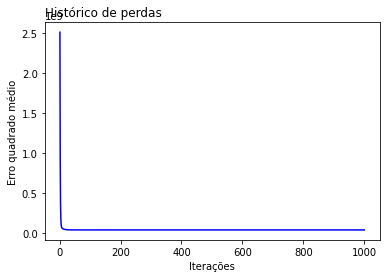

In [43]:
# Estudo de convergência

fig = plt.figure()

plt.plot(range(1, itera + 1), hPerda, color = 'blue')

plt.xlabel('Iterações')

plt.ylabel('Erro quadrado médio')

plt.title('Histórico de perdas', loc = 'left')

# 5 SIGNIFICÂNCIA ESTATÍSTICA

## 5.1 Recap sumário do modelo

In [44]:
print(reg1fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           1.34e-27
Time:                        21:18:36   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## 5.2 Reajuste do modelo (modelo reduzido)

### 5.2.1 Nova matrix do modelo

In [45]:
ols_formula(dfFull, 'Profit', 'adm')

'Profit ~ rd + mkt + ca + fl + ny'

In [46]:
y, Xred = pt.dmatrices(ols_formula(dfFull, 'Profit', 'adm'), data = dfFull , return_type='dataframe')

In [47]:
# Especificação do modelo
reg2 = sm.OLS(y, Xred)

# Executa o método dos mínimos quadrados
reg2fit = reg2.fit()

In [48]:
print(reg2fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     215.8
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           9.72e-29
Time:                        21:18:36   Log-Likelihood:                -525.53
No. Observations:                  50   AIC:                             1061.
Df Residuals:                      45   BIC:                             1071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04    993.420     84.567      0.0

# 6 QUALIDADE DE AJUSTE

## 6.1 Separar os datasets

In [49]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [50]:
xTrain.reset_index(drop=True, inplace=True)
xTest.reset_index(drop=True, inplace=True)
yTrain.reset_index(drop=True, inplace=True)
yTest.reset_index(drop=True, inplace=True)

## 6.2 Ajuste do modelo - mínimos quadrados

### 6.2.1 Modelo 'full'

In [172]:
reg3 = sm.OLS(yTrain, xTrain)
reg3fit = reg3.fit()

In [173]:
print(reg3fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     145.1
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           4.15e-24
Time:                        22:26:01   Log-Likelihood:                -473.01
No. Observations:                  45   AIC:                             958.0
Df Residuals:                      39   BIC:                             968.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.333e+04   1082.962     76.948      0.0

### 6.2.2 Modelo 'reduzido' 

In [157]:
xTrainRed = xTrain.drop(['adm'], axis = 1)

In [182]:
reg4 = sm.OLS(yTrain, xTrainRed.drop(['ca'], axis=1))
reg4fit = reg4.fit()

In [183]:
print(reg4fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     186.0
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           2.85e-25
Time:                        22:41:21   Log-Likelihood:                -473.01
No. Observations:                  45   AIC:                             956.0
Df Residuals:                      40   BIC:                             965.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.112e+05   2390.740     46.533      0.0

## 6.3 Avaliação de multicolinearidade

In [156]:
pd.DataFrame({'Variaveis': xTrainRed.columns[1:],
              'VIF': [variance_inflation_factor(xTrainRed.values, i+1) for i in range(len(xTrainRed.columns[1:]))]})

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variaveis,VIF
0,rd,2.055984
1,mkt,2.126109
2,ca,inf
3,fl,inf
4,ny,inf


## 6.4 Qualidade de ajuste (Mínimos Quadrados)

In [57]:
predY = pd.concat([yTest, reg4fit.predict(xTest.drop('adm', axis = 1))], axis = 1)

In [58]:
predY.columns = ['profReal', 'profPred']
predY

,profReal,profPred
0,103282.38,101173.929112
1,144259.40,133503.979045
2,146121.95,132672.287753
3,77798.83,72860.882041
4,191050.39,178540.806994


In [59]:
print('Rquadrado', metrics.r2_score(predY['profReal'], predY['profPred']))

Rquadrado 0.9365755604263571


In [60]:
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predY['profReal'], predY['profPred'])))

Raiz do erro quadrado médio 9817.24051507419


## 6.5 Qualidade de ajuste (Gradiente descendente)

### 6.5.1 Ajuste do modelo reduzido

In [61]:
# Salvar o tamanho do df com os regressores (incluindo o intercept)
m, n = xTrainRed.shape

# Inicializa a série de betas
beta = np.zeros(n)

In [62]:
beta, hPerda = grad_des(X = xTrainRed , y = yTrain, beta = beta, alpha = alpha, itera = itera)

### 6.5.2 Criar matrix com previões

In [63]:
predGradY = pd.concat([yTest, xTest.drop('adm', axis=1).dot(beta)], axis = 1)

In [64]:
predGradY

,Profit,0
0,103282.38,101173.929112
1,144259.40,133503.979045
2,146121.95,132672.287753
3,77798.83,72860.882041
4,191050.39,178540.806994


In [65]:
predGradY.columns = ['profReal', 'profPred']

### 6.5.3 Métricas de qualidade

In [66]:
print('Rquadrado', metrics.r2_score(predGradY['profReal'], predGradY['profPred']))
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predGradY['profReal'], predGradY['profPred'])))

Rquadrado 0.9365755604263568
Raiz do erro quadrado médio 9817.24051507422


# 7 ANÁLISE DE RESÍDUOS

## 7.1 Calculo dos Resíduos

In [67]:
# Gerar previsões
predY = pd.concat([yTrain, reg4fit.predict(xTrainRed)], axis = 1)

In [68]:
predY.columns = ['profReal', 'profPred']

In [69]:
predY['Res'] = predY['profReal'] - predY['profPred']

In [70]:
predY.head()

,profReal,profPred,Res
0,105008.31,115244.039573,-10235.729573
1,81229.06,69446.146726,11782.913274
2,97483.56,98298.998430,-815.438430
3,110352.25,113231.200990,-2878.950990
4,166187.94,168374.289616,-2186.349616


## 7.2 Distribuição dos resíduos

(array([ 1.,  0.,  0.,  2.,  2.,  6., 16.,  8.,  6.,  4.]),
 array([-33786.66537421, -28779.23009423, -23771.79481424, -18764.35953425,
        -13756.92425427,  -8749.48897428,  -3742.05369429,   1265.3815857 ,
          6272.81686568,  11280.25214567,  16287.68742566]),
 <a list of 10 Patch objects>)

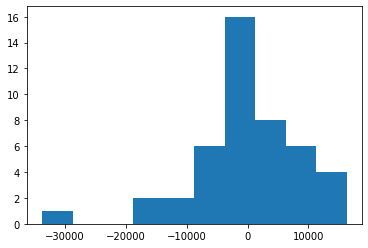

In [71]:
fig = plt.figure()
plt.hist(predY['Res'])

In [72]:
kStat, kPvalue = sp.stats.kstest(predY['Res'], 'norm')

In [73]:
kStat

0.5111111111111111

In [74]:
kPvalue

1.9730177301725436e-11

In [75]:
# Ajuste do modelo com Log da resposta
reg5 = sm.OLS(np.log(yTrain), xTrainRed)
reg5fit = reg5.fit()

In [76]:
# Cálculo dos resíduos
predLogY = pd.concat([np.log(yTrain), reg5fit.predict(xTrainRed)], axis = 1)

predLogY.columns = ['profLogReal', 'profLogPred']

predLogY['LogRes'] = predLogY['profLogReal'] - predLogY['profLogPred']

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  9., 16., 18.]),
 array([-1.25037585, -1.10267465, -0.95497345, -0.80727225, -0.65957105,
        -0.51186985, -0.36416865, -0.21646744, -0.06876624,  0.07893496,
         0.22663616]),
 <a list of 10 Patch objects>)

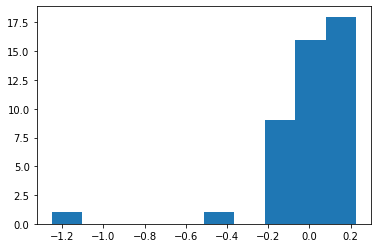

In [77]:
fig = plt.figure()
plt.hist(predLogY['LogRes'])

In [78]:
kStat, kPvalue = sp.stats.kstest(predLogY['LogRes'], 'norm')

In [79]:
kStat

0.4103533362594217

In [80]:
kPvalue

2.285315188032897e-07

## 7.3 Homocedasticidade

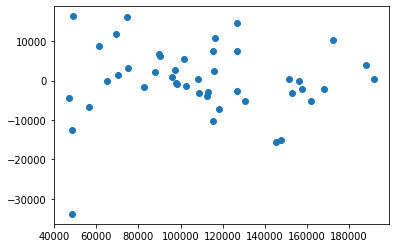

In [81]:
fig = plt.figure()
plt.scatter(predY['profPred'], predY['Res'])

# 8 REGRESSÃO REGULARIZADA

In [235]:
# Especificar o modelo
regRidge = Ridge(alpha=0.1)

In [236]:
regRidge.fit(xTrain.drop(['Intercept', 'ca'], axis=1), yTrain)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [237]:
print(regRidge.coef_)

[[35547.43545277   214.93479161  4047.11894302 -1148.90169109
    806.98268321]]


In [238]:
print(regRidge.intercept_)

[111215.66068219]


In [239]:
# Prever valores para o dataset de testex
predYReg = pd.concat([yTest, pd.DataFrame(regRidge.predict(xTest.drop(['Intercept', 'ca'], axis = 1)))], axis = 1)

In [240]:
predYReg

,Profit,0
0,103282.38,101523.476025
1,144259.40,133141.110375
2,146121.95,132416.399246
3,77798.83,72754.571035
4,191050.39,178164.745985


In [241]:
predYReg.columns = ['Profit', 'predProfit']

In [242]:
print('Rquadrado', metrics.r2_score(predYReg['Profit'], predYReg['predProfit']))
print('Raiz do erro quadrado médio', 
      np.sqrt(metrics.mean_squared_error(predYReg['Profit'], predYReg['predProfit'])))

Rquadrado 0.9333976274210263
Raiz do erro quadrado médio 10060.184879396556
